<a href="https://colab.research.google.com/github/makikah/Time_Series_Python/blob/main/Diabetes_ClassificationUsingMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import Library

In [1]:
#básica
import pandas as pd
import numpy as np
import scipy as sc
import seaborn as sns
#matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
#scikit learn
from sklearn import linear_model
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier

# TensorFlow e tf.keras
import tensorflow as tf
from tensorflow import keras

#read files from drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Load DataFrame

Pode ser encontrado [aqui](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

In [3]:
from google.colab import files
uploated = files.upload()

Saving dados_diabetes.csv to dados_diabetes.csv


In [4]:
import io
data = pd.read_csv(io.BytesIO(uploated["dados_diabetes.csv"]))
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [5]:
print(data.dtypes)

Pregnancies                   int64
Glucose                     float64
BloodPressure               float64
SkinThickness               float64
Insulin                     float64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


In [6]:
#Renomear columnas
data = data.rename(columns={'Pregnancies':'Preg', 'Glucose':'Gluc', 'BloodPressure':'BP', 'SkinThickness':'ST', 'Insulin':'Ins',
       'DiabetesPedigreeFunction':'DPF', "Age":"Idade", "Outcome":"Classe"})
data.columns

Index(['Preg', 'Gluc', 'BP', 'ST', 'Ins', 'BMI', 'DPF', 'Idade', 'Classe'], dtype='object')

In [7]:
#target variável balance
print('Sample size: ',len(data))
print('Number of variables: ',len(data.columns)-1)
print('\nLabel frequencies')
print('Outcomes:')
print(data["Classe"].value_counts())

Sample size:  768
Number of variables:  8

Label frequencies
Outcomes:
0    500
1    268
Name: Classe, dtype: int64


Há um total de 768 amostras e que cada amostra é descrita por 8 atributos treináveis a serem analisadas para prever 1 variável dependente binária (sendo igual a ‘1’ para o caso de diagnóstico positivo para diabetes, e ‘0’ caso contrário).

In [8]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Preg,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Gluc,768.0,121.677083,30.464161,44.000,99.75000,117.0000,140.25000,199.00
BP,768.0,72.389323,12.106039,24.000,64.00000,72.0000,80.00000,122.00
ST,768.0,29.089844,8.890820,7.000,25.00000,28.0000,32.00000,99.00
Ins,768.0,141.753906,89.100847,14.000,102.50000,102.5000,169.50000,846.00
BMI,768.0,32.434635,6.880498,18.200,27.50000,32.0500,36.60000,67.10
DPF,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Idade,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Classe,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


#A) Análise Exploratória de Dados (EDA)

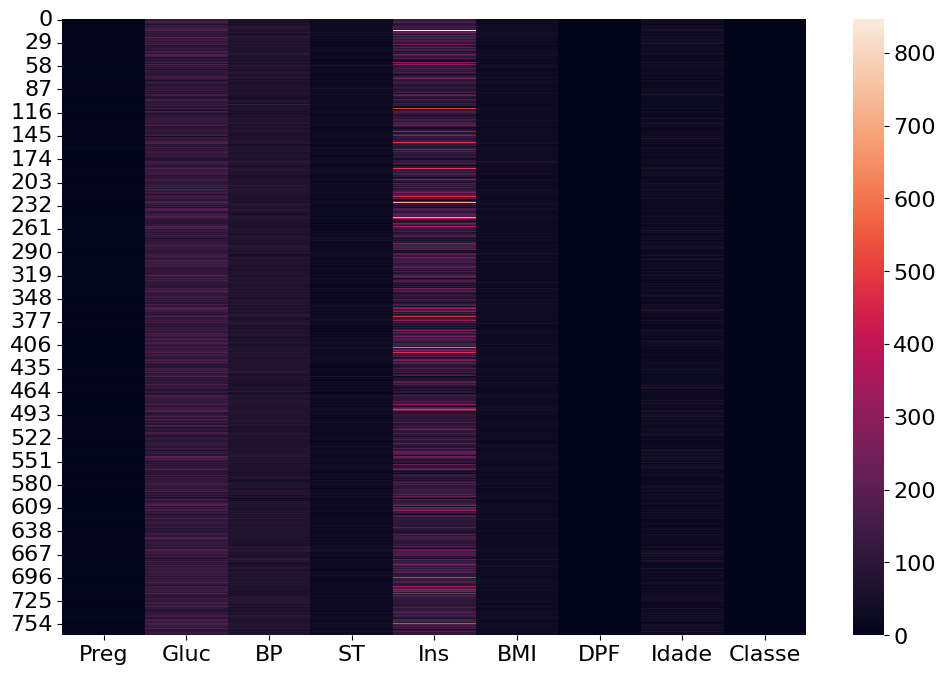

In [9]:
#Visual dataset
plt.figure(figsize=(12,8))
plt.rcParams["font.size"] = "16"
sns.heatmap(data, cbar=True)
plt.show()

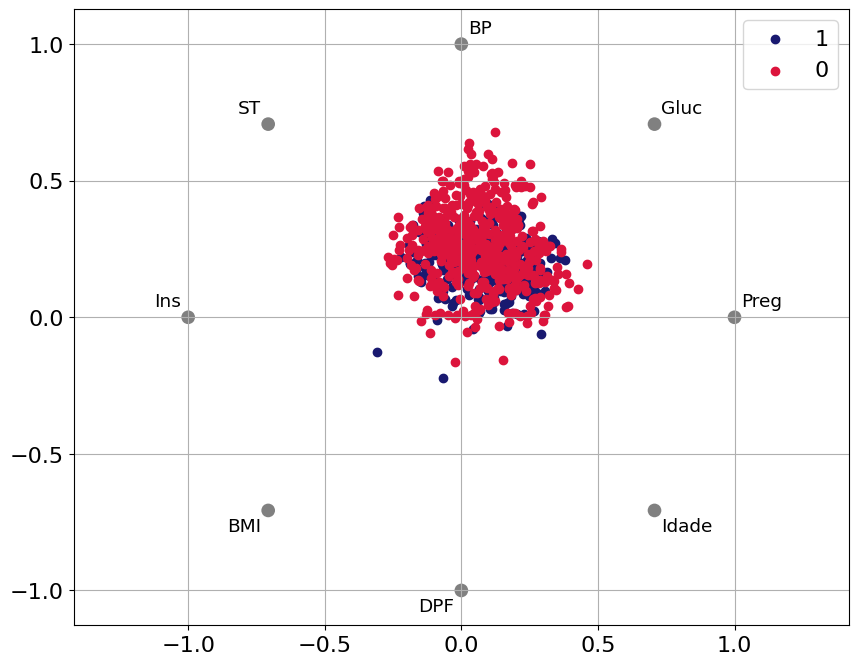

In [10]:
from pandas.plotting import radviz

plt.figure(figsize=(10,8))
plt.rcParams["font.size"] = "16"
radviz(data, "Classe", color=["midnightblue", "crimson"])
plt.grid()
plt.show()

<ipython-input-11-63e6cef4c1e5>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 4, i+1)
<ipython-input-11-63e6cef4c1e5>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 4, i+1)
<ipython-input-11-63e6cef4c1e5>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 4, i+1)
<ipython-input-11-63e6cef4c1e5>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 4, i+1)
<ipython-input-11-63e6cef4c1e5>:5: MatplotlibDeprecationWarning: Auto-re

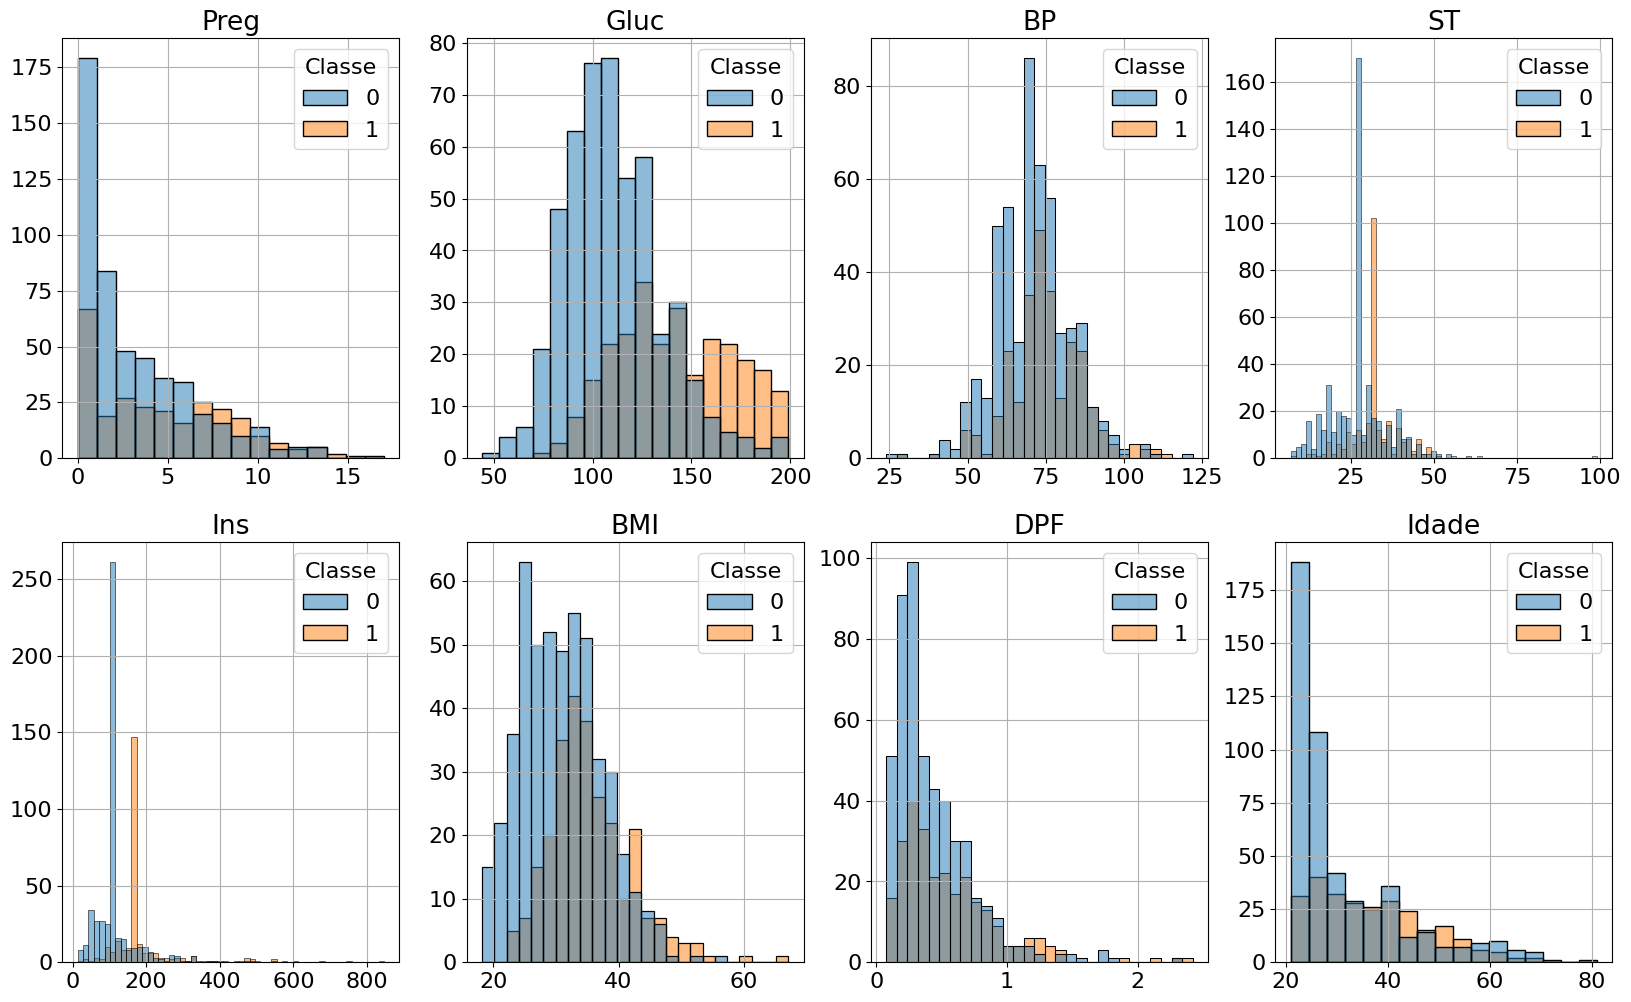

In [11]:
#Histogram
f, axs = plt.subplots(5, 4,figsize=(20,12))
plt.rcParams["font.size"] = "16"
for i,col in enumerate(data.columns[:8]):
    plt.subplot(2, 4, i+1)
    sns.histplot(data,x=col,hue="Classe")
    plt.title(col)
    plt.grid()
    plt.xlabel("")
    plt.ylabel("") 

Em geral, isso sugere que o conjunto de dados não é uniformemente distribuído ou não normalizado. Mas, pode-se ver que Alguns dos atributos parecem normalmente distribuídos (Glucose, BloodPressure, BMI).

Alguns dos atributos parecem ter uma distribuição exponencial (Skin Thickness, insulin, Pregnancies,DiabetesPredigreeFunction, age).

É claro que aqui qualquer fator não pesa muito na detecção de diabetes. Portanto, precisamos prosseguir com os cruzamentos de recursos e analisar. (pairplot)

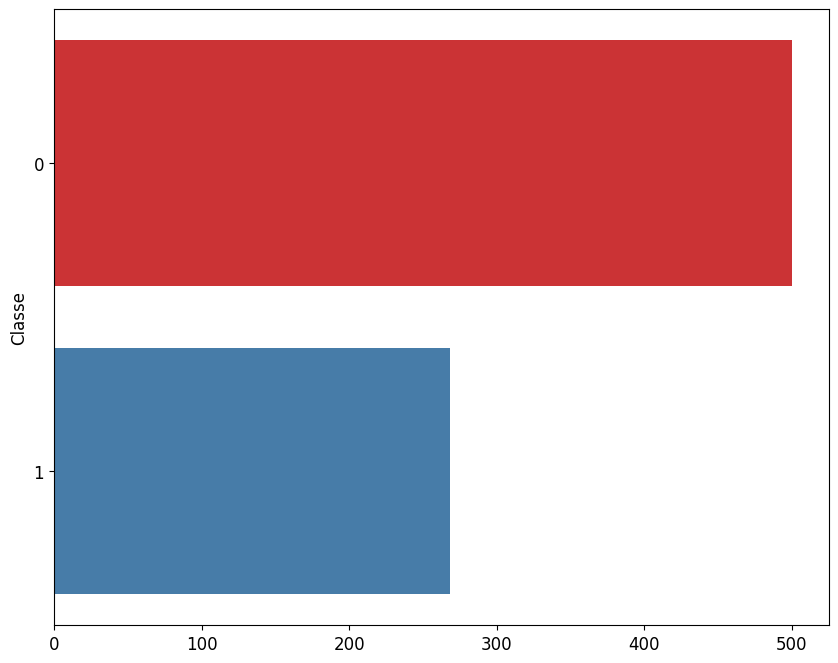

In [28]:
plt.figure(figsize=(10,8))
plt.rcParams["font.size"] = "12"
sns.countplot(y=data["Classe"],palette="Set1", orient="v")
plt.grid(False)
plt.xlabel("")
plt.show()

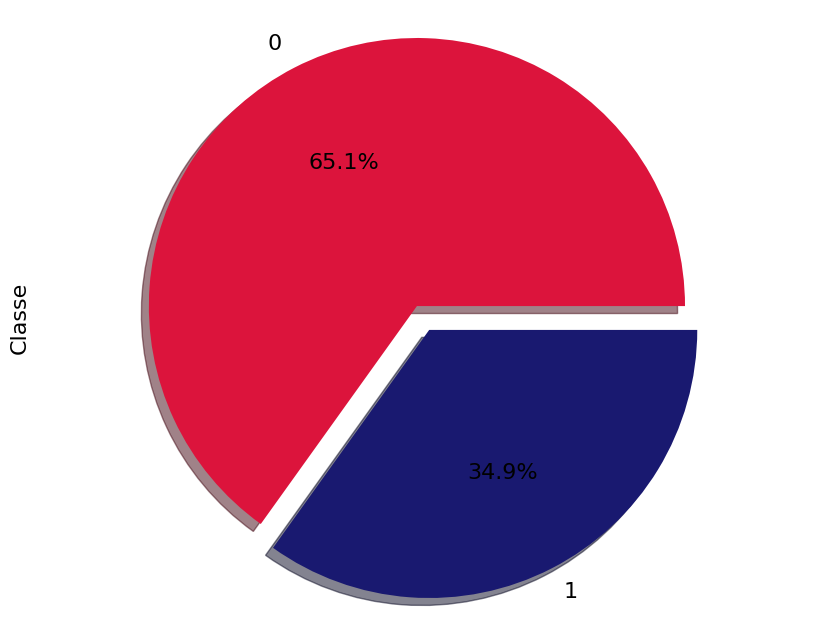

In [22]:
from matplotlib.patches import Shadow
plt.figure(figsize=(10,8))
plt.rcParams["font.size"] = "16"
colors = ["crimson", "midnightblue"]
data['Classe'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True, 
                                       explode=(0, 0.1), colors=colors)              

# For a neat display of the plot
_ = plt.axis('equal')

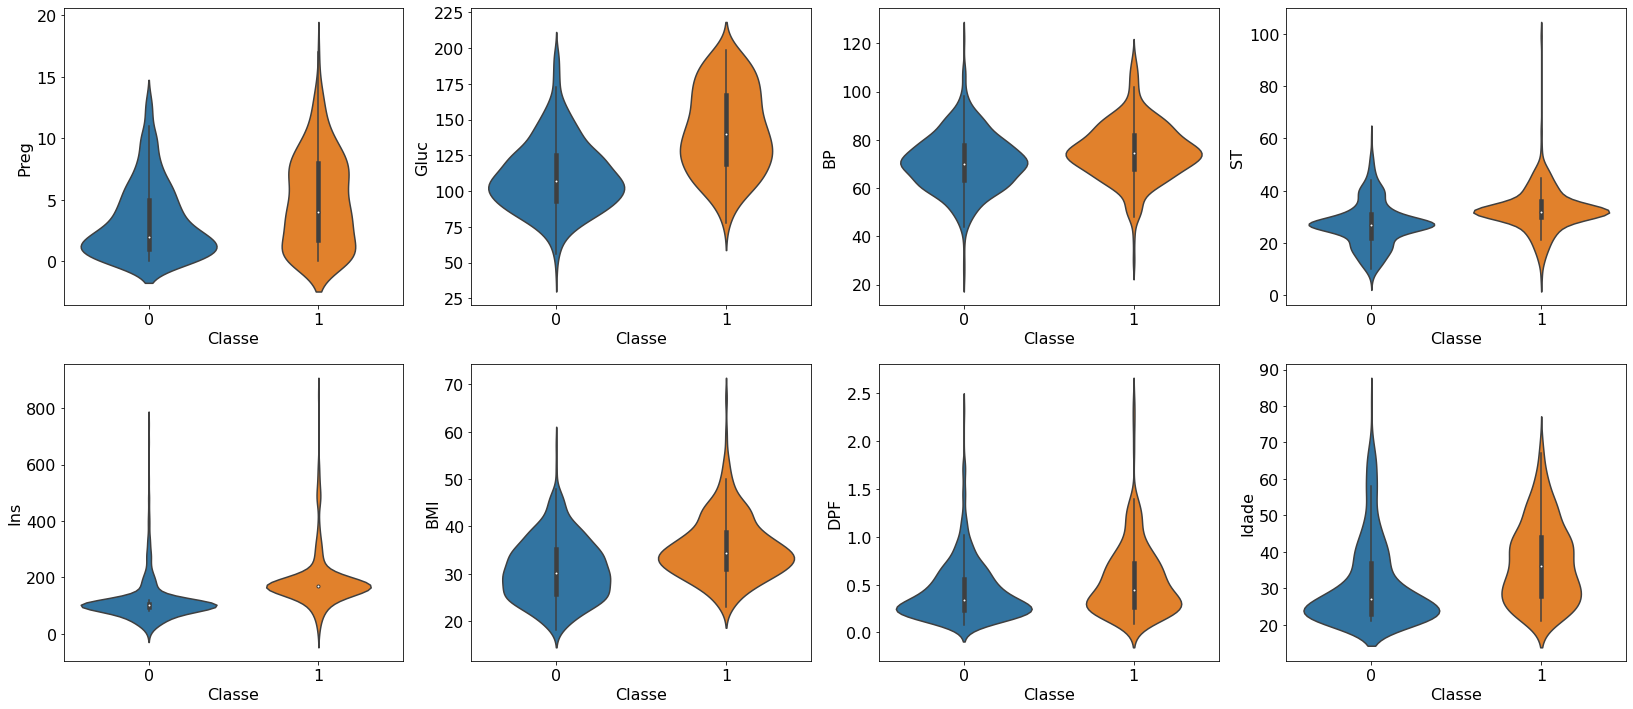

In [ ]:
f, axes = plt.subplots(2,4, figsize=(28,12))
plt.rcParams["font.size"] = "16"
sns.violinplot(x=data.Classe, y=data.Preg, ax=axes[0,0])
sns.violinplot(x=data.Classe ,y=data.Gluc, ax=axes[0,1])
sns.violinplot(x=data.Classe ,y=data.BP, ax=axes[0,2])
sns.violinplot(x=data.Classe ,y=data.ST, ax=axes[0,3])
sns.violinplot(x=data.Classe ,y=data.Ins, ax=axes[1,0])
sns.violinplot(x=data.Classe ,y=data.BMI, ax=axes[1,1])
sns.violinplot(x=data.Classe ,y=data.DPF, ax=axes[1,2])
sns.violinplot(x=data.Classe ,y=data.Idade, ax=axes[1,3])
plt.grid(False)
plt.show()

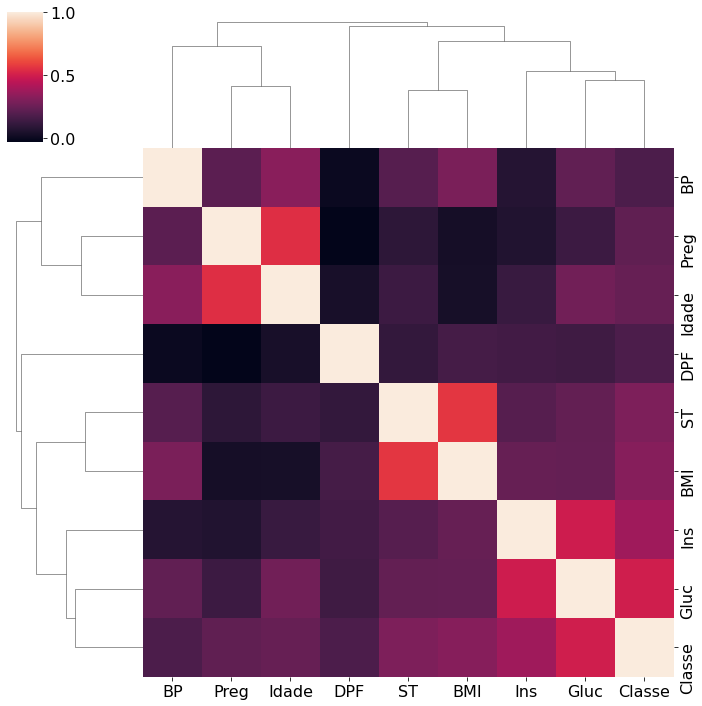

In [ ]:
plt.rcParams["font.size"] = "16"
sns.clustermap(data.corr())
plt.show()

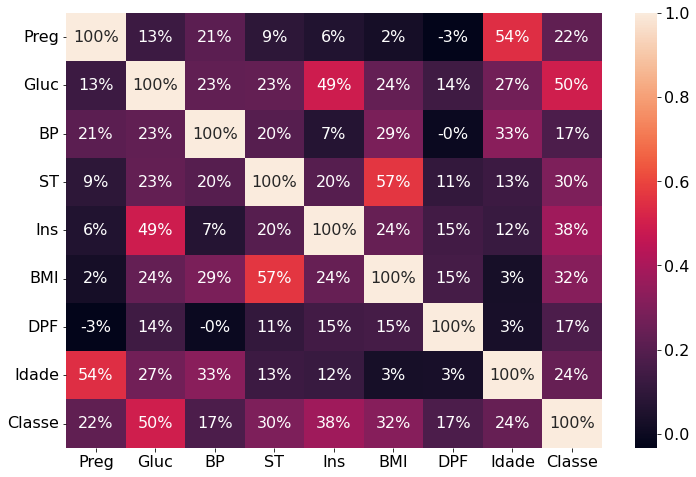

In [ ]:
plt.figure(figsize=(12,8))
plt.rcParams["font.size"] = "16"
sns.heatmap(data.corr(), annot=True,fmt=".0%")
plt.show()

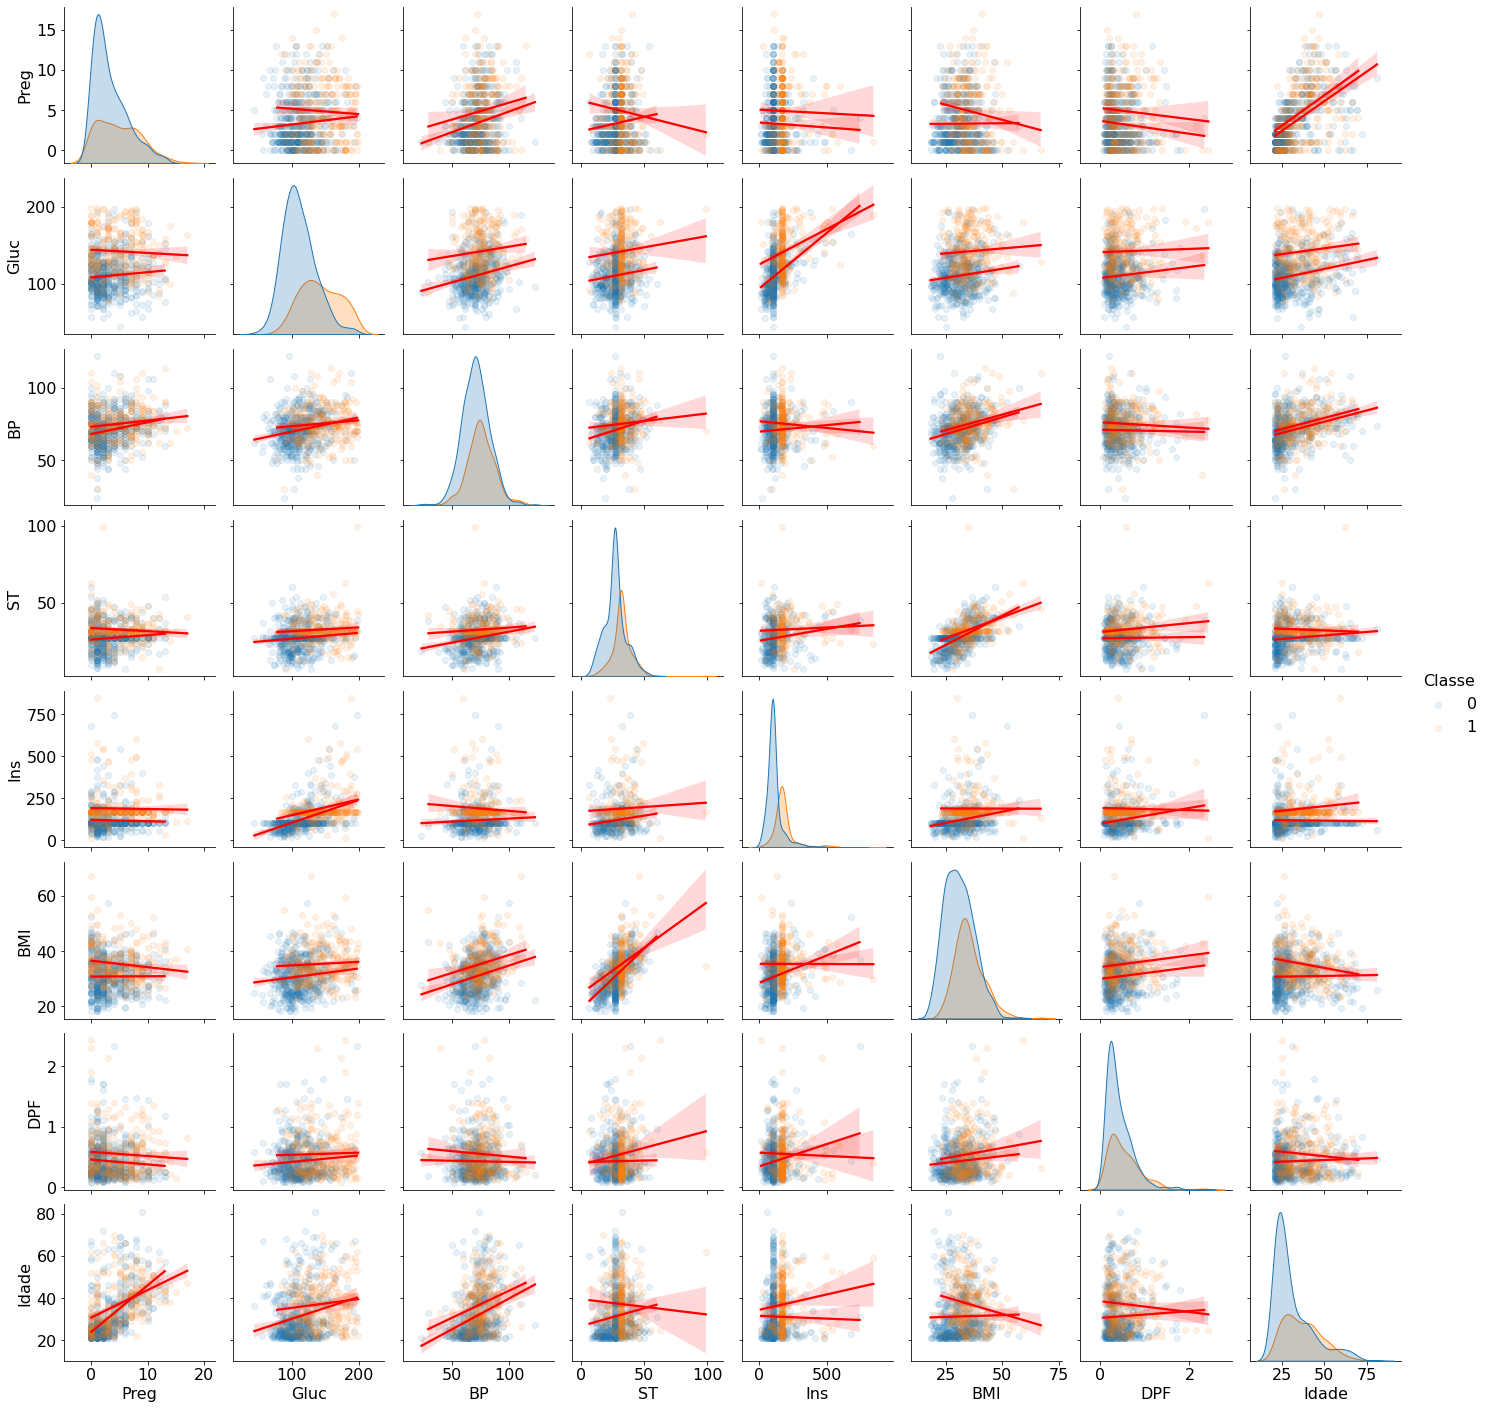

In [ ]:
sns.pairplot(data, hue="Classe", kind='reg', 
             plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})
plt.show()

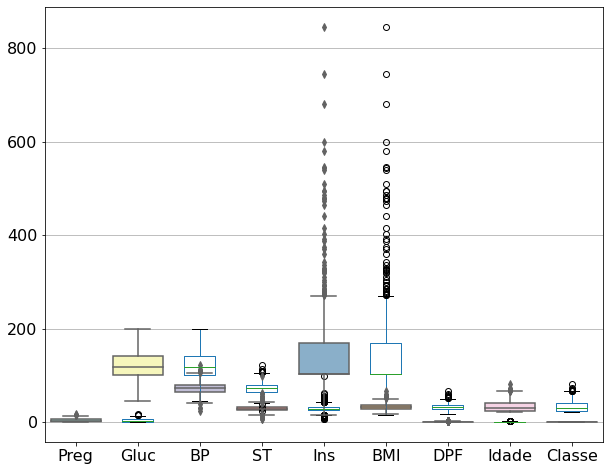

In [ ]:
data.boxplot(figsize=(10,8))
sns.boxplot(hue=None, color=".25",
                 data=data, palette="Set3")
plt.show()

Como vimos na figura acima, existe, portanto, presença de "outliers". Porém, passamos na normalização dos atributos de entradas. Foi usada a formula : z = x-mu/std da função sklearn.preprocessing.StandardScaler do scikit learn.

onde mu é a média das amostras de treinamento, std é o desvio padrão das amostras de treinamento. Com parâmetros : copy = False, isto é, o dimensionamento local; with_mean = True, isto é, centralizar os dados antes de escalar; emfim, with_std = True, isto é, dimensionar os dados de forma que o desvio padrão seja unidade. Com atributos, o número de amostras processadas pelo estimador para cada 8 atributos.

#B) Considere uma rede MLP com uma única camada intermediária

##Divisões estratificadas de dados em treino-teste

Alguns problemas de classificação não têm um número equilibrado de exemplos para cada rótulo de classe. Como tal, é desejável dividir o conjunto de dados em conjuntos de treinamento e teste de uma forma que preserve as mesmas proporções dos exemplos em cada classe, conforme observado no conjunto de dados original.

Isso é chamado de divisão estratificada de teste de trem.

Podemos conseguir isso definindo o argumento “estratificar” para o componente y do conjunto de dados original. Isso será usado pela função train_test_split () para garantir que os conjuntos de treinamento e teste tenham a proporção de exemplos em cada classe que está presente no array “y” fornecido.

In [ ]:
features = list(data.columns.values)
features.remove('Classe')
print(features)
X = data[features]
y = data['Classe']
X.shape, y.shape

['Preg', 'Gluc', 'BP', 'ST', 'Ins', 'BMI', 'DPF', 'Idade']


((768, 8), (768,))

###Normalização

In [ ]:
X = (X - np.min(X))/(np.max(X)-np.min(X)) 

In [ ]:
X.shape, y.shape

((768, 8), (768,))

In [ ]:
import time
inicio = time.time() #registra o tempo no inicio da função


#STRATIFIED HOLDOUT
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

#Salva o maior valor(mode=max) da acurácia dos dados de validação (monitor=val_accuracy)
from keras.callbacks import ModelCheckpoint
ckpt_model = 'pima-weights.best.hdf5'
checkpoint = ModelCheckpoint(ckpt_model, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

#Encerra o treinamento do fold e vai para o proximo se o custo não diminuir em 8 épocas 
from keras.callbacks import EarlyStopping
stop = EarlyStopping(monitor='loss', patience=8,verbose=0)

#faz a lista dos "callbacks":
'''
A callback is an object that can perform actions at various stages of training 
(e.g. at the start or end of an epoch, before or after a single batch, etc).
https://keras.io/api/callbacks/
'''
callbacks_list = [stop, checkpoint]


#cria dataframe e variaveis para armazenar as acuracias de validação e nº de neuronios
acc2 = pd.DataFrame()
train_acc2 = []
val_acc2 = []
neuron2 = []

#Iteração para nº de neuronios de 5 a 150 (passo=5)
for i in range(5,201,5):
  accuracy = []
    # create model
  model = keras.Sequential([
    keras.layers.Dense(i, input_dim=8, activation='relu'), #camada intermediaria junto com input
    keras.layers.Dense(1,activation='sigmoid')]) #camada de saída (sigmoide pois a saida é 0 ou 1)
  # Compile model
  '''
  Usamos crossentropy  por causa de ser um problema de classificação binaria
  igual no EFC que usamos log-loss
  '''
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  # Fit the model
  '''
  Cria o objeto history que armazenara informações sobre o modelo (treino/validação)
  '''
  history2 = model.fit(X_train, y_train, 
          epochs=300,
          validation_data=(X_test, y_test), 
          batch_size=16,
          callbacks=callbacks_list, 
          verbose=0)
  #armazena a qtd de neuronios da iteração atual
  neuron2.append(i)
      
  # evaluate the model
  scores = model.evaluate(X_test, y_test, verbose=0)#Returns the loss value[0] & metrics[1] values for the model in test mode.
  #acurácia do fold (k de 5)
  #accuracy.append(scores[1])
  #acurácia média para i neuronios  
  train_acc2.append(scores[1])
  val_acc2.append(scores[1])
  print('accuracy of:', round(scores[1],3),'for',i,'neurons')

acc2['train_acc']=train_acc2
acc2["val_acc"] = val_acc2
acc2['neurons']=np.unique(neuron2)
print('numero de neuronios com maior acuracia: ',acc2['neurons'][acc2['train_acc'].idxmax()])
fim = time.time() #registra o tempo no fim da função
tempo = fim - inicio
print(round(tempo,2)/60, 'minutes elapsed')

accuracy of: 0.773 for 5 neurons
accuracy of: 0.87 for 10 neurons
accuracy of: 0.857 for 15 neurons
accuracy of: 0.883 for 20 neurons
accuracy of: 0.786 for 25 neurons
accuracy of: 0.87 for 30 neurons
accuracy of: 0.844 for 35 neurons
accuracy of: 0.864 for 40 neurons
accuracy of: 0.883 for 45 neurons
accuracy of: 0.851 for 50 neurons
accuracy of: 0.87 for 55 neurons
accuracy of: 0.864 for 60 neurons
accuracy of: 0.851 for 65 neurons
accuracy of: 0.877 for 70 neurons
accuracy of: 0.87 for 75 neurons
accuracy of: 0.877 for 80 neurons
accuracy of: 0.857 for 85 neurons
accuracy of: 0.864 for 90 neurons
accuracy of: 0.857 for 95 neurons
accuracy of: 0.864 for 100 neurons
accuracy of: 0.851 for 105 neurons
accuracy of: 0.864 for 110 neurons
accuracy of: 0.857 for 115 neurons
accuracy of: 0.877 for 120 neurons
accuracy of: 0.864 for 125 neurons
accuracy of: 0.87 for 130 neurons
accuracy of: 0.857 for 135 neurons
accuracy of: 0.864 for 140 neurons
accuracy of: 0.864 for 145 neurons
accuracy o

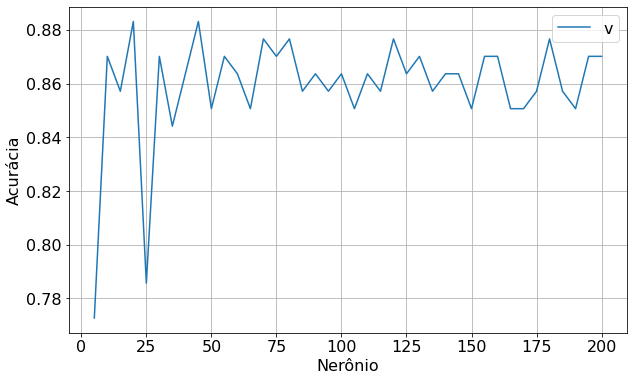

In [ ]:
# plt.figure(figsize=(10,6))
# plt.rcParams["font.size"] = "16"
# plt.plot(acc2['neurons'],acc2['train_acc'])
# plt.xlabel("Nerônio")
# plt.ylabel("Acurácia")
# plt.legend("t")
# plt.show()

plt.figure(figsize=(10,6))
plt.rcParams["font.size"] = "16"
plt.plot(acc2['neurons'],acc2['val_acc'])
plt.grid()
plt.xlabel("Nerônio")
plt.ylabel("Acurácia")
plt.legend("v")
plt.show()

Devido à aleatoriedade o numero ideal de neurônios fica variando, entretanto, os melhores valores de neurônios, considerando a taxa de acerto (acurácia), são superiores a 27. Portanto, vamos considerar número de "ótimo" de neurônio a 95.

In [ ]:
history2.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

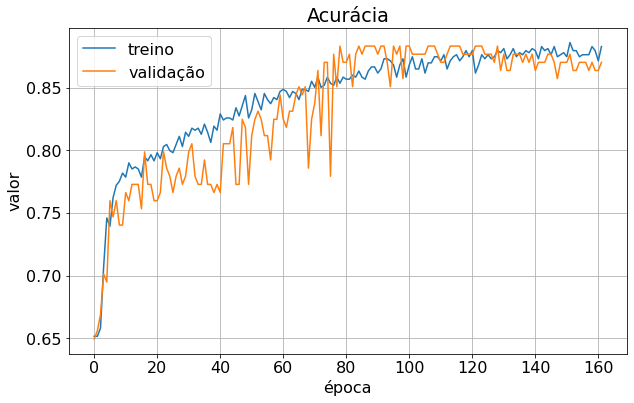

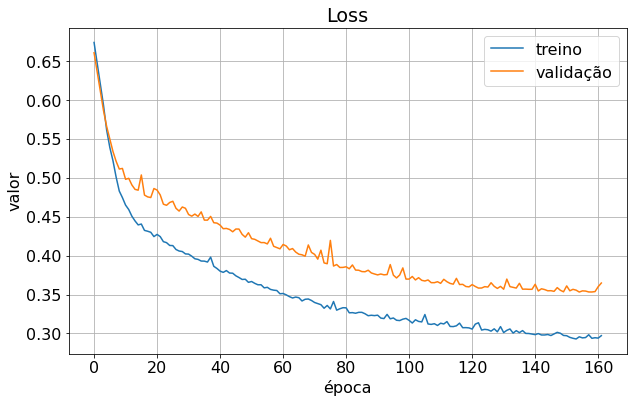

In [ ]:
plt.figure(figsize=(10,6))
plt.rcParams["font.size"] = "16"
plt.plot(history2.history["accuracy"], label="treino")
plt.plot(history2.history["val_accuracy"], label="validação")
plt.title("Acurácia")
plt.ylabel("valor")
plt.xlabel("época")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(history2.history["loss"], label="treino")
plt.plot(history2.history["val_loss"], label="validação")
plt.title("Loss")
plt.xlabel("época")
plt.ylabel("valor")
plt.grid()
plt.legend()
plt.show()

#C) Utilizando o número “ótimo” de neurônios na camada intermediária.

In [ ]:
# create modelo com 35 neurônios "ótimos"
model = keras.Sequential([
  keras.layers.Dense(54, input_dim=8, activation='relu'), #camada intermediaria junto com input
  keras.layers.Dense(1, activation='sigmoid' )]) #camada de saída (sigmoide pois a saida é 0 ou 1)
# Compile modelo
'''
Usamos crossentropy  por causa de ser um problema de classificação binaria
igual no EFC que usamos log-loss
'''
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit modelo
'''
Cria o objeto history que armazenara informações sobre o modelo (treino/validação)
'''
history = model.fit(X_train, y_train, 
        epochs=500,
        validation_data=(X_test, y_test), 
        batch_size=16,
        callbacks=callbacks_list, 
        verbose=0)

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
model.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 54)                486       
                                                                 
 dense_81 (Dense)            (None, 1)                 55        
                                                                 
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


##Função custo e acurácia com número de neurônio "ótimo"

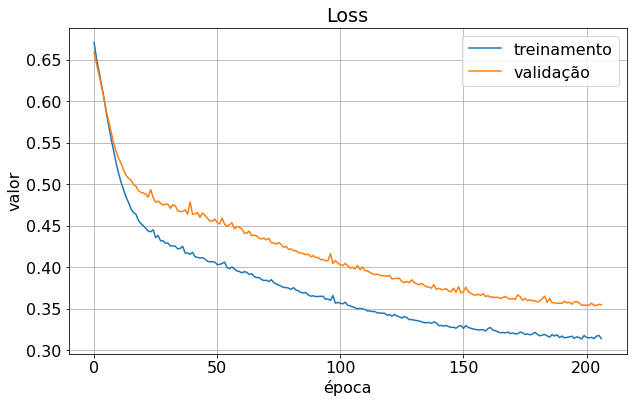

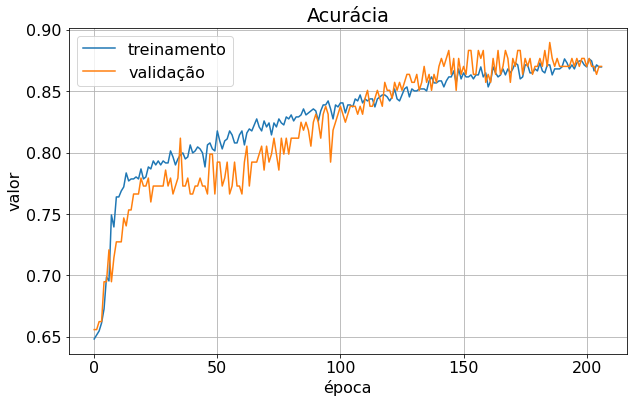

In [ ]:
plt.figure(figsize=(10,6))
plt.rcParams["font.size"] = "16"
plt.plot(history.history["loss"], label="treinamento")
plt.plot(history.history["val_loss"], label="validação")
plt.title("Loss")
plt.xlabel("época")
plt.ylabel("valor")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(history.history["accuracy"], label="treinamento")
plt.plot(history.history["val_accuracy"], label="validação")
plt.title("Acurácia")
plt.ylabel("valor")
plt.xlabel("época")
plt.grid()
plt.legend()
plt.show()

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 87.01%


###Matriz de confusão

In [ ]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

5/5 [==============================] - 0s 4ms/step


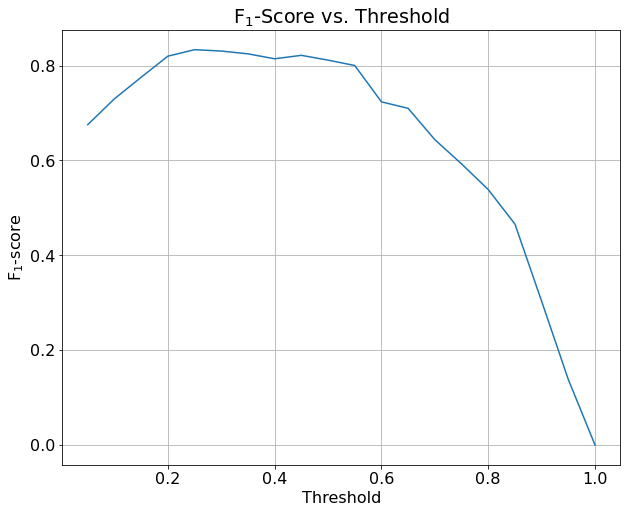

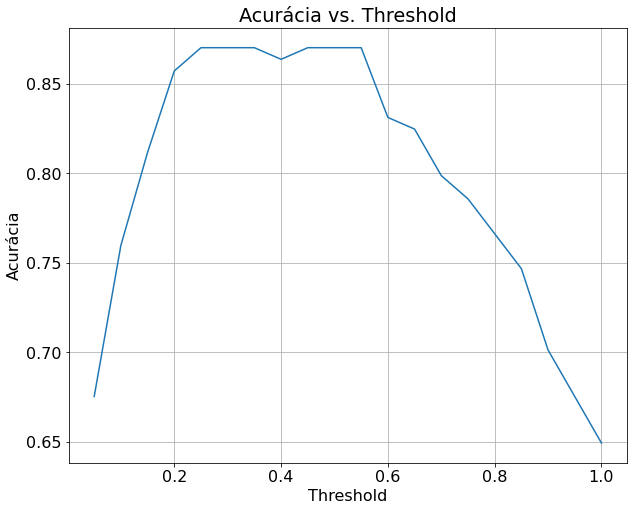

best threshold f1:  0.24999999999999933
best threshold accuracy:  0.5499999999999996 

Acuracy of the model for 0.5 treshold:87.01%
Acuracy of the model for best f1 treshold:87.01%
Acuracy of the model for best accuracy treshold:87.01%

Confusion Matrix



array([[94,  6],
       [14, 40]])

In [ ]:
pred_proba_df = pd.DataFrame(model.predict(X_test)) #probabilidades para todas as classes pelo rótulo da classe.
threshold_list = list(np.arange(1,0,-0.05))

f1 = []
act = []
fxt = pd.DataFrame()

for i in threshold_list:
    y_test_pred = pred_proba_df.applymap(lambda x: 1 if x > i else 0) #toma a decisão se 1 ou 0 com base na probabilidade do limiar
    f1score = metrics.f1_score(y_test, y_test_pred.iloc[:,0])
    acuracia = accuracy_score(y_test, y_test_pred.iloc[:,0])
    f1.append(f1score)
    act.append(acuracia)

fxt['f1'] = f1
fxt['acc'] = act
fxt['t'] = threshold_list

plt.figure(figsize=(10,8))
plt.rcParams["font.size"] = "16"
plt.title("F$_1$-Score vs. Threshold")
plt.plot(fxt['t'],fxt['f1'] , "")
plt.grid()
plt.ylabel("F$_1$-score")
plt.xlabel("Threshold")
plt.show()

plt.figure(figsize=(10,8))
plt.rcParams["font.size"] = "16"
plt.title("Acurácia vs. Threshold")
plt.plot(fxt['t'],fxt['acc'] , "")
plt.grid()
plt.ylabel("Acurácia")
plt.xlabel("Threshold")
plt.show()

limiar = fxt['t'][fxt['f1'].idxmax()]
limiar2 = fxt['t'][fxt['acc'].idxmax()]
print('best threshold f1: ',limiar)
print('best threshold accuracy: ',limiar2,'\n')

pred_proba_df['classificação'] = np.where(pred_proba_df.iloc[:,0]>0.5,1,0)
ac = accuracy_score(y_test,pred_proba_df['classificação'])
print(f"Acuracy of the model for 0.5 treshold:{round(ac*100,2)}%")

pred_proba_df['classificação'] = np.where(pred_proba_df.iloc[:,0]>limiar,1,0)
ac = accuracy_score(y_test,pred_proba_df['classificação'])
print(f"Acuracy of the model for best f1 treshold:{round(ac*100,2)}%")

pred_proba_df['classificação'] = np.where(pred_proba_df.iloc[:,0]>limiar2,1,0)
ac = accuracy_score(y_test,pred_proba_df['classificação'])
print(f"Acuracy of the model for best accuracy treshold:{round(ac*100,2)}%")

#Matriz de confusão
y_true = y_test
y_pred = pred_proba_df['classificação']
print('\nConfusion Matrix\n')
confusion_matrix(y_true, y_pred)

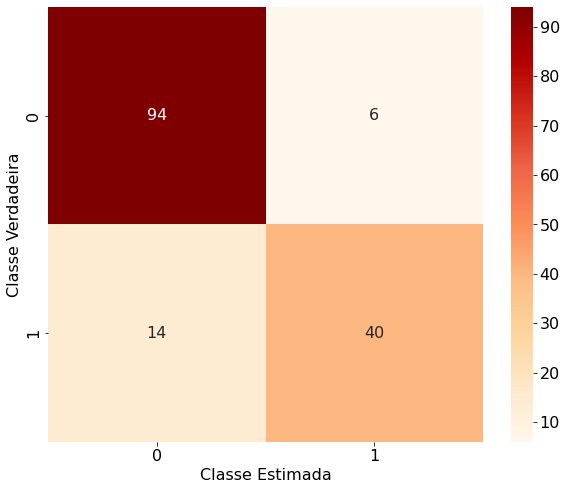

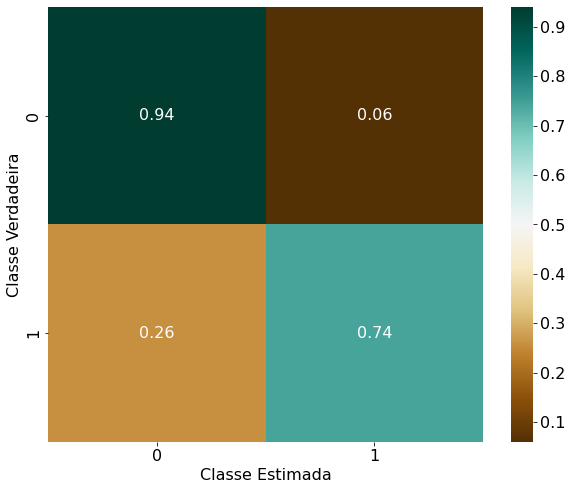

In [ ]:
# criando uma matriz de confusão 
cm = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cm)

plt.figure(figsize=(10,8))
plt.rcParams["font.size"] = "16"
sns.heatmap(df_cm, square=True, annot=True,fmt='d',cmap=plt.cm.OrRd)
#plt.title("Absolute Confusion Matrix",fontsize = 15)
plt.xlabel("Classe Estimada")
plt.ylabel("Classe Verdadeira")
plt.show()

cm = confusion_matrix(y_true, y_pred,normalize='true')
df_cm = pd.DataFrame(cm)

plt.figure(figsize=(10,8))
plt.rcParams["font.size"] = "16"
sns.heatmap(df_cm, square=True, annot=True,fmt='.2g',cmap=plt.cm.BrBG)
#plt.title("Normalized Confusion Matrix",fontsize = 15)
plt.xlabel("Classe Estimada")
plt.ylabel("Classe Verdadeira")
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90       100
           1       0.87      0.74      0.80        54

    accuracy                           0.87       154
   macro avg       0.87      0.84      0.85       154
weighted avg       0.87      0.87      0.87       154



In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score

In [ ]:
print('accuracy is {:.3f}'.format(accuracy_score(y_true,y_pred)))
print('roc-auc is {:.3f}'.format(roc_auc_score(y_true,y_pred)))

accuracy is 0.870
roc-auc is 0.840


In [ ]:
# def get_confusion_matrix(y_test, y_pred):
#     n_classes = len(np.unique(y_test))
#     conf = np.zeros((n_classes, n_classes))
#     for actual, pred in zip(y_test, y_pred):
#         conf[int(actual)][int(pred)] += 1
#     return conf.astype('int')

In [ ]:
# def get_roc_curve(y_test, y_pred, delta=0.1):
#     """
#     Return the True Positive Rates (TPRs), False Positive Rates (FPRs), 
#     and the threshold values, seperated by delta.
#     """
#     thresh = list(np.arange(0, 1, delta)) + [1]
#     TPRs = []
#     FPRs = []
#     y_pred = np.empty(y_pred.shape)
#     for th in thresh:
#         y_pred[y_pred < th] = 0
#         y_pred[y_pred >= th] = 1
        
#         # matriz de confusão da função que definimos
#         (TN, FP), (FN, TP) = get_confusion_matrix(y_test, y_pred)
        
#         TPR = TP / (TP + FN)  # sensitivity
#         FPR = FP / (FP + TN)  # 1 - specificity
#         TPRs.append(TPR)
#         FPRs.append(FPR)
#     return FPRs, TPRs, thresh

In [ ]:
delta = 0.001

In [ ]:
auc_score = metrics.roc_auc_score(y_test, y_pred)
print(f"Scikit's ROC-AUC score of SVC model is {auc_score: .4f}")

Scikit's ROC-AUC score of SVC model is  0.8404


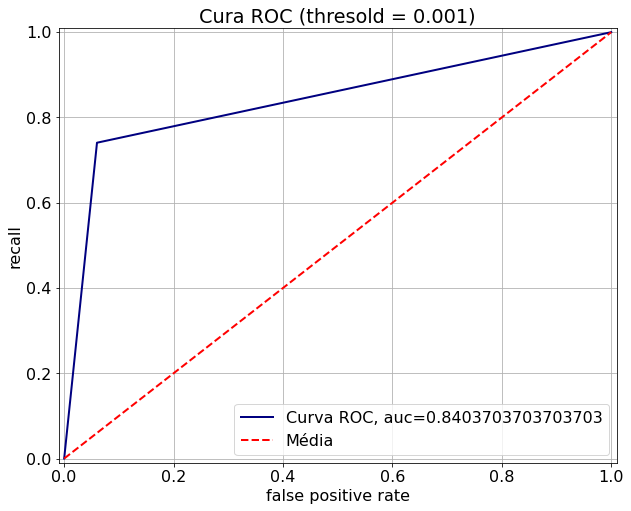

In [ ]:
def plot_roc(y_true, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.plot(fpr, tpr, color="navy", lw=2, label="Curva ROC, auc="+str(auc_score))
    ax.plot([0, 1], [0, 1], color="red",lw=2, linestyle='--', label="Média") 
    ax.grid(True)
    ax.set(title="Cura ROC {}".format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
    plt.legend(loc="lower right")
    plt.ylabel("recall")
    plt.xlabel("false positive rate")

plot_roc(y_true, y_pred, "(thresold = 0.001)")
plt.show()

##Precision-Recall

In [ ]:
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
# from sklearn.metrics import plot_precision_recall_curve
# import scikitplot as skplt
from sklearn.metrics import average_precision_score